# Implementation of ***CART***
This notebook demonstrates the implementation of the ***CART*** for Parkinson’s Disease detection using three feature processing methods:  
1. All Features (`Toutes caractéristiques`).  
2. Feature Selection (`La Sélection des caractéristiques`): ***Wrapper***, ***Embedding***, and ***ANOVA***.  
3. Dimensionality Reduction (`Réduction des données`) using ***PCA***.  

Each method is applied in two ways:  
- Using standard libraries.  
- Using custom implementations developed from scratch.  

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


from sklearn.tree import DecisionTreeClassifier, plot_tree
from Models.cart.main import CARTClassifier


## 1. Data Preprocessing  
- **Dataset**: Parkinson's Disease Classification (UCI Machine Learning Repository).  
- **Steps**:  
  1. Load and explore the dataset.  
  2. Standard Scaker for feature scaling.
  3. Balance classes using SMOTE.  
- Code snippets for preprocessing are shared below.


In [67]:

# Load the data
data = pd.read_csv("pd_speech_features.csv", header=1)


# Preprocess numeric columns
def safe_convert_numeric(df):
    numeric_columns = df.select_dtypes(include=['object']).columns
    for col in numeric_columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except Exception as e:
            print(f"Error converting column {col}: {e}")
    return df

data = safe_convert_numeric(data)

# Scale the features
scaler = StandardScaler()

# Identify numeric columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns[1:-1]
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Identify binary/categorical columns and other features
binary_features = ['gender']  # Adjust if needed
other_features = [col for col in data.columns if col not in binary_features + ['id', 'class']]

# Aggregate features with mean and std
aggregated_data = data.groupby('id')[other_features].agg(['mean', 'std']).reset_index()

# Flatten multi-level column names
aggregated_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in aggregated_data.columns]

# Add binary features back as-is
for feature in binary_features:
    aggregated_data[feature] = data.groupby('id')[feature].first().values.astype(data[feature].dtype)

# Add the target variable
aggregated_data['class'] = data.groupby('id')['class'].first().values

# Separate features and target
X = aggregated_data.drop(['class', 'id_'], axis=1)
y = aggregated_data['class']


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## 2.1 Method 1: Using All Features  
This section applies the ***CART*** on the dataset using all features without any feature selection.  

### Implementation Approaches:  
1. **Using Standard Libraries** (e.g., scikit-learn, CatBoost).  
2. **Custom Implementation** of ***CART***.  

### Evaluation Metrics:  
- Accuracy, Precision, Recall, F1-Score, ROC-AUC.



Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.54      0.54        13
           1       0.84      0.84      0.84        38

    accuracy                           0.76        51
   macro avg       0.69      0.69      0.69        51
weighted avg       0.76      0.76      0.76        51


ROC AUC Score: 0.6902834008097165


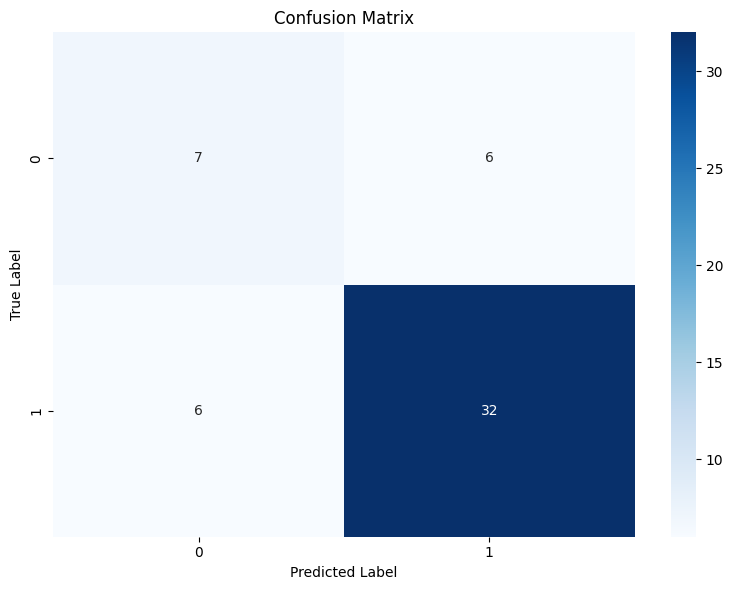

In [68]:

# Initialize and train the Decision Tree Classifier from sklearn
dt_classifier = DecisionTreeClassifier(
    random_state=42, 
    max_depth=7,  # Limiting the depth to prevent overfitting
    criterion='gini',
    min_samples_split=2,
)
dt_classifier.fit(X_train, y_train)

# Predictions
y_pred = dt_classifier.predict(X_test)


# Evaluation Metrics
print("\nClassification Report:")
AllFeatures_DT_report = classification_report(y_test, y_pred)
AllFeatures_DT_accuracy = accuracy_score(y_test, y_pred)
print(AllFeatures_DT_report)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"\nROC AUC Score: {roc_auc}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.46      0.50        13
           1       0.82      0.87      0.85        38

    accuracy                           0.76        51
   macro avg       0.69      0.66      0.67        51
weighted avg       0.75      0.76      0.76        51


ROC AUC Score: 0.6649797570850202


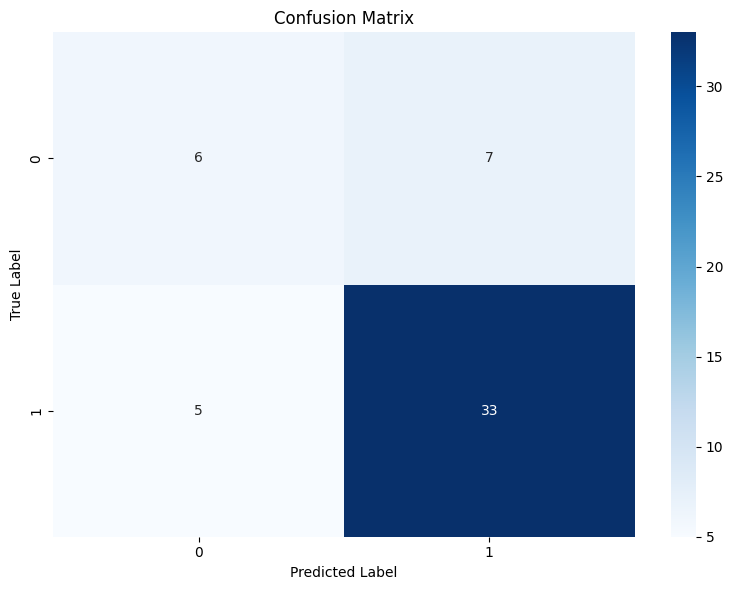

In [69]:

# Initialize and train the Decision Tree Classifier from scratch
cart_classifier = CARTClassifier(max_depth=7)
cart_classifier.fit(X_train, y_train)

# Predictions
y_pred = cart_classifier.predict(X_test)

# Evaluation Metrics
print("\nClassification Report:")
AllFeatues_cart_report = classification_report(y_test, y_pred)
AllFeatues_cart_accuracy = accuracy_score(y_test, y_pred)
print(AllFeatues_cart_report)


# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"\nROC AUC Score: {roc_auc}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## 2.2 Method 2: Feature Selection  
Features are selected using three techniques: Wrapper, Embedding, and ANOVA. The union of selected features is used for model training.  

### Sub-methods:  
1. **Wrapper Method**: Backward elimination.  
2. **Embedding Method**: Lasso L1
3. **ANOVA**: Statistical test for feature importance.  

### Evaluation Metrics:  
- Accuracy, Precision, Recall, F1-Score, ROC-AUC.


In [70]:
from SelectionType.EFSA.main import FeatureSelector

# Initialize the Feature Selector
selector = FeatureSelector(X_train, y_train)
selected_features = selector.comprehensive_feature_selection(k_features=30) # Perform feature selection based on anova embedding and wrapper methods

print(f"\nSelected Features: {selected_features}")


Selected Features: ['tqwt_kurtosisValue_dec_18_mean', 'tqwt_entropy_log_dec_36_std', 'tqwt_stdValue_dec_12_mean', 'tqwt_maxValue_dec_11_mean', 'ddpJitter_mean', 'rapJitter_mean', 'tqwt_maxValue_dec_12_mean', 'locAbsJitter_std', 'ddpJitter_std', 'tqwt_TKEO_mean_dec_21_mean', 'tqwt_medianValue_dec_12_std', 'std_delta_delta_log_energy_mean', 'tqwt_skewnessValue_dec_30_std', 'tqwt_stdValue_dec_11_mean', 'mean_MFCC_2nd_coef_mean', 'locShimmer_mean', 'mean_9th_delta_delta_std', 'ppq5Jitter_std', 'tqwt_minValue_dec_12_mean', 'ppq5Jitter_mean', 'locAbsJitter_mean', 'PPE_mean', 'tqwt_meanValue_dec_25_std', 'std_7th_delta_delta_mean', 'tqwt_minValue_dec_11_mean', 'tqwt_medianValue_dec_31_std', 'mean_MFCC_6th_coef_mean', 'tqwt_medianValue_dec_22_std', 'tqwt_TKEO_std_dec_11_mean', 'rapJitter_std']



Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.54      0.61        13
           1       0.85      0.92      0.89        38

    accuracy                           0.82        51
   macro avg       0.78      0.73      0.75        51
weighted avg       0.81      0.82      0.82        51


ROC AUC Score: 0.7297570850202428


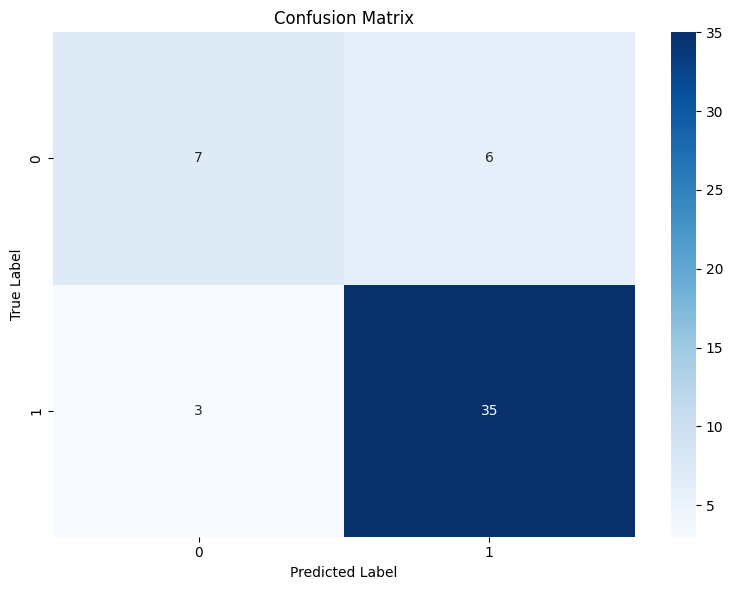

In [71]:

X_train_transformed = X_train[selected_features]
X_test_transformed = X_test[selected_features]

# train the Sklearn Decision Tree Classifier with the selected features
dt_classifier_selection = DecisionTreeClassifier(
    random_state=42, 
    max_depth=7,  # Limiting the depth to prevent overfitting
    criterion='gini',
    min_samples_split=2,
)

dt_classifier_selection.fit(X_train_transformed, y_train)

# Predictions
y_pred = dt_classifier_selection.predict(X_test_transformed)

# Evaluation Metrics
print("\nClassification Report:")
SelectedFeatures_DT_report = classification_report(y_test, y_pred)
SelectedFeatures_DT_accuracy = accuracy_score(y_test, y_pred)
print(SelectedFeatures_DT_report)


# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"\nROC AUC Score: {roc_auc}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.62      0.64        13
           1       0.87      0.89      0.88        38

    accuracy                           0.82        51
   macro avg       0.77      0.76      0.76        51
weighted avg       0.82      0.82      0.82        51


ROC AUC Score: 0.7550607287449393


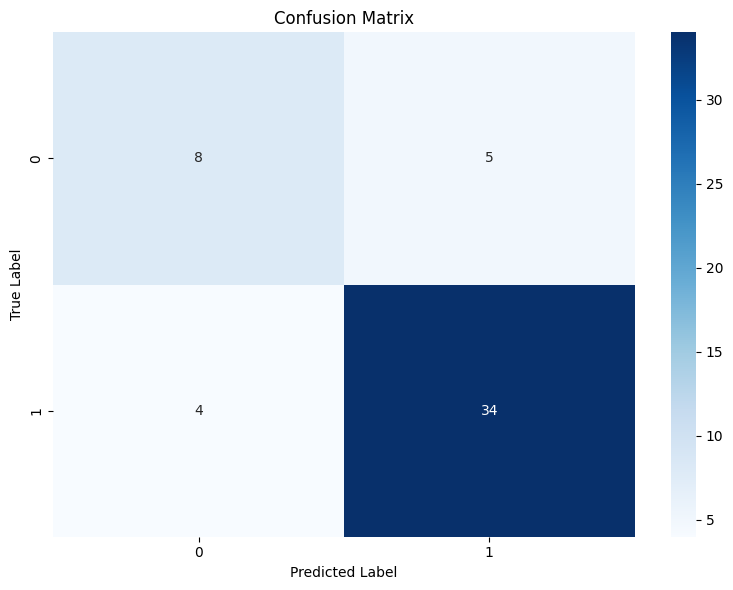

In [72]:


# train the Cart Classifier with the selected features
cart_classifier_selection = CARTClassifier(max_depth=7)
cart_classifier_selection.fit(X_train_transformed, y_train)

# Predictions
y_pred = cart_classifier_selection.predict(X_test_transformed)

# Evaluation Metrics
print("\nClassification Report:")
SelectedFeatures_cart_report = classification_report(y_test, y_pred)
SelectedFeatures_cart_accuracy = accuracy_score(y_test, y_pred)
print(SelectedFeatures_cart_report)


# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"\nROC AUC Score: {roc_auc}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


## 2.3 Method 3: Dimensionality Reduction  
Principal Component Analysis (PCA) is used to reduce the dataset's dimensionality before applying the **CART**.   

### Evaluation Metrics:  
- Accuracy, Precision, Recall, F1-Score, ROC-AUC.


C:\Users\bouma\AppData\Local\Temp\ipykernel_30116\2226459482.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train_pca = X_train_pca.astype(float)
C:\Users\bouma\AppData\Local\Temp\ipykernel_30116\2226459482.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  X_test_pca = X_test_pca.astype(float)


Fold 1: CART Accuracy = 0.8039, DT Accuracy = 0.7647


C:\Users\bouma\AppData\Local\Temp\ipykernel_30116\2226459482.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train_pca = X_train_pca.astype(float)
C:\Users\bouma\AppData\Local\Temp\ipykernel_30116\2226459482.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  X_test_pca = X_test_pca.astype(float)


Fold 2: CART Accuracy = 0.8039, DT Accuracy = 0.7843


C:\Users\bouma\AppData\Local\Temp\ipykernel_30116\2226459482.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train_pca = X_train_pca.astype(float)
C:\Users\bouma\AppData\Local\Temp\ipykernel_30116\2226459482.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  X_test_pca = X_test_pca.astype(float)


Fold 3: CART Accuracy = 0.8000, DT Accuracy = 0.8200


C:\Users\bouma\AppData\Local\Temp\ipykernel_30116\2226459482.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train_pca = X_train_pca.astype(float)
C:\Users\bouma\AppData\Local\Temp\ipykernel_30116\2226459482.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  X_test_pca = X_test_pca.astype(float)


Fold 4: CART Accuracy = 0.8200, DT Accuracy = 0.8400


C:\Users\bouma\AppData\Local\Temp\ipykernel_30116\2226459482.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train_pca = X_train_pca.astype(float)
C:\Users\bouma\AppData\Local\Temp\ipykernel_30116\2226459482.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  X_test_pca = X_test_pca.astype(float)


Fold 5: CART Accuracy = 0.7200, DT Accuracy = 0.7400

Overall Performance:
CART Mean Accuracy: 0.7896
DT Mean Accuracy: 0.7898

Mean Precision (DT): 0.8289
Mean Recall (DT): 0.9049
Mean Precision (CART): 0.8324
Mean Recall (CART): 0.8992


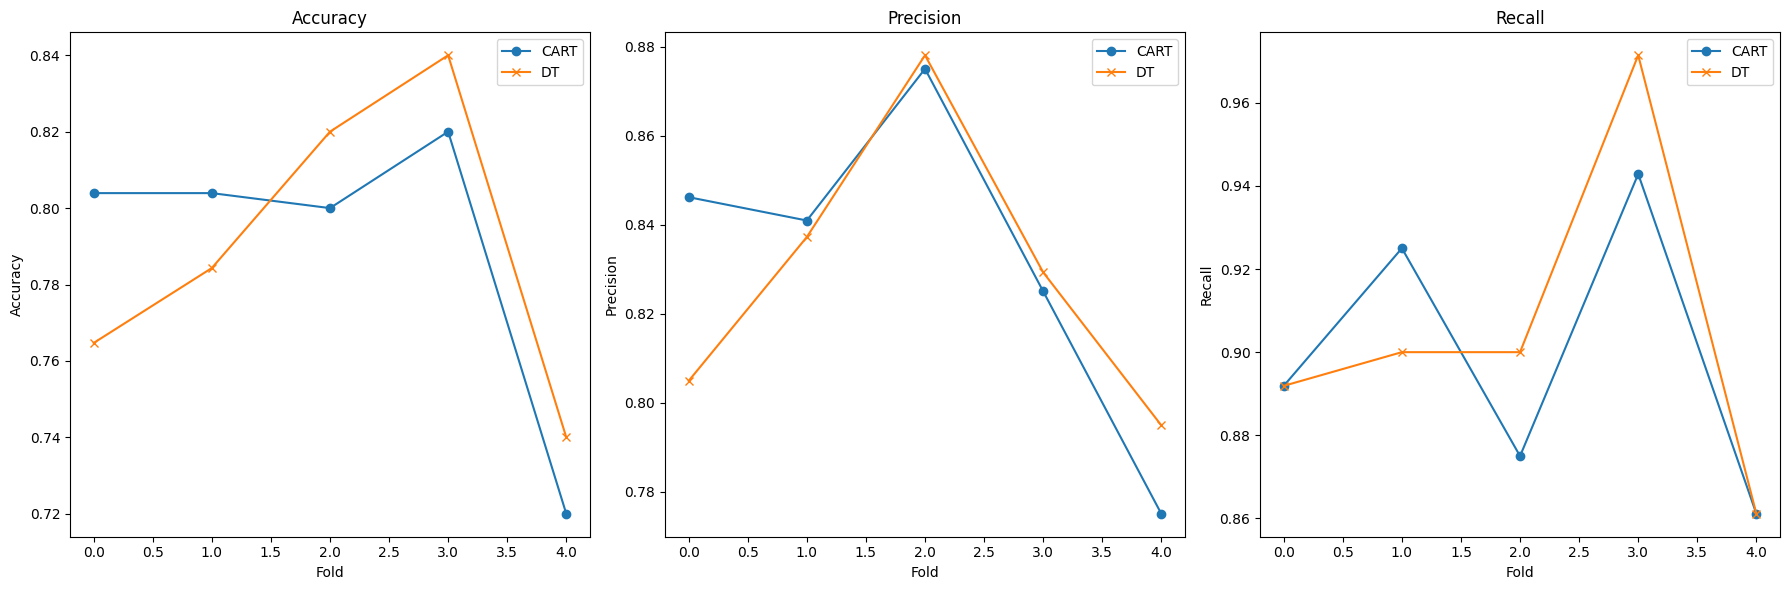

In [76]:
from SelectionType.acp import PCAFromScratch

# Assuming `aggregated_data` is your processed dataset
X = aggregated_data.drop(columns=['class', 'id_']).values
y = aggregated_data['class'].values

# Feature names for PCA and scaling
feature_names = aggregated_data.drop(columns=['class', 'id_']).columns

# Initialize PCA
pca = PCAFromScratch(n_components=80)  # Adjust number of components as needed

# Initialize the custom CARTClassifier
cart_model_PCA = CARTClassifier(max_depth=7, min_samples_split=2)

DT_model_PCA = DecisionTreeClassifier(
    random_state=42, 
    max_depth=7,  # Limiting the depth to prevent overfitting
    criterion='gini',
    min_samples_split=2,
)

# k-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
DT_accuracies = []
DT_reports = []
cart_accuracies = []
cart_reports = []
fold = 1


for train_index, test_index in kf.split(X):
    # Split into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA to the training and test sets
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    
    # # cast complex data to float
    X_train_pca = X_train_pca.astype(float)
    X_test_pca = X_test_pca.astype(float)
    

    # Train the CARTClassifier on PCA-transformed data
    cart_model_PCA.fit(X_train_pca, y_train)
    
    # Train the Sklearn Decision Tree Classifier on PCA-transformed data
    DT_model_PCA.fit(X_train_pca, y_train)

    # Predict on the test set
    y_pred_cart = cart_model_PCA.predict(X_test_pca)
    
    # Predict on the test set
    y_pred_DT = DT_model_PCA.predict(X_test_pca)

    # Evaluate the models
    rep_cart = classification_report(y_test, y_pred_cart, output_dict=True)
    rep_DT = classification_report(y_test, y_pred_DT, output_dict=True)
    cart_reports.append(rep_cart)
    DT_reports.append(rep_DT)
    acc_cart = accuracy_score(y_test, y_pred_cart)
    acc_DT = accuracy_score(y_test, y_pred_DT)
    cart_accuracies.append(acc_cart)
    DT_accuracies.append(acc_DT)
    print(f"Fold {fold}: CART Accuracy = {acc_cart:.4f}, DT Accuracy = {acc_DT:.4f}")
    fold += 1


# Overall performance
print("\nOverall Performance:")
print(f"CART Mean Accuracy: {np.mean(cart_accuracies):.4f}")
print(f"DT Mean Accuracy: {np.mean(DT_accuracies):.4f}")

# average precision and recall from the kfold cross validation from reports
dt_mean_precision = np.mean([rep['1']['precision'] for rep in DT_reports])
dt_mean_recall = np.mean([rep['1']['recall'] for rep in DT_reports])
cart_mean_precision = np.mean([rep['1']['precision'] for rep in cart_reports])
cart_mean_recall = np.mean([rep['1']['recall'] for rep in cart_reports])


print(f"\nMean Precision (DT): {dt_mean_precision:.4f}")
print(f"Mean Recall (DT): {dt_mean_recall:.4f}")
print(f"Mean Precision (CART): {cart_mean_precision:.4f}")
print(f"Mean Recall (CART): {cart_mean_recall:.4f}")




#plot the accusies and precisions and recalls
cart_accuracies = [rep['accuracy'] for rep in cart_reports]
DT_accuracies = [rep['accuracy'] for rep in DT_reports]

cart_precisions = [rep['1']['precision'] for rep in cart_reports]
DT_precisions = [rep['1']['precision'] for rep in DT_reports]

cart_recalls = [rep['1']['recall'] for rep in cart_reports]
DT_recalls = [rep['1']['recall'] for rep in DT_reports]

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].plot(cart_accuracies, label='CART', marker='o')
ax[0].plot(DT_accuracies, label='DT', marker='x')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Fold')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(cart_precisions, label='CART', marker='o')
ax[1].plot(DT_precisions, label='DT', marker='x')
ax[1].set_title('Precision')
ax[1].set_xlabel('Fold')
ax[1].set_ylabel('Precision')
ax[1].legend()

ax[2].plot(cart_recalls, label='CART', marker='o')
ax[2].plot(DT_recalls, label='DT', marker='x')
ax[2].set_title('Recall')
ax[2].set_xlabel('Fold')
ax[2].set_ylabel('Recall')
ax[2].legend()

plt.tight_layout()
plt.show()



## 3. Comparative Analysis  
- **Objective**: Compare the performance of the *CART* across:  
  1. All Features.  
  2. Feature Selection.  
  3. PCA.  
- **Comparison Metrics**:  
  - Performance (Accuracy, Precision, Recall, F1-Score, ROC-AUC).  
  - Computational efficiency (Training and Testing Time).  
- Present results as tables and visualizations (e.g., bar plots, ROC curves).  


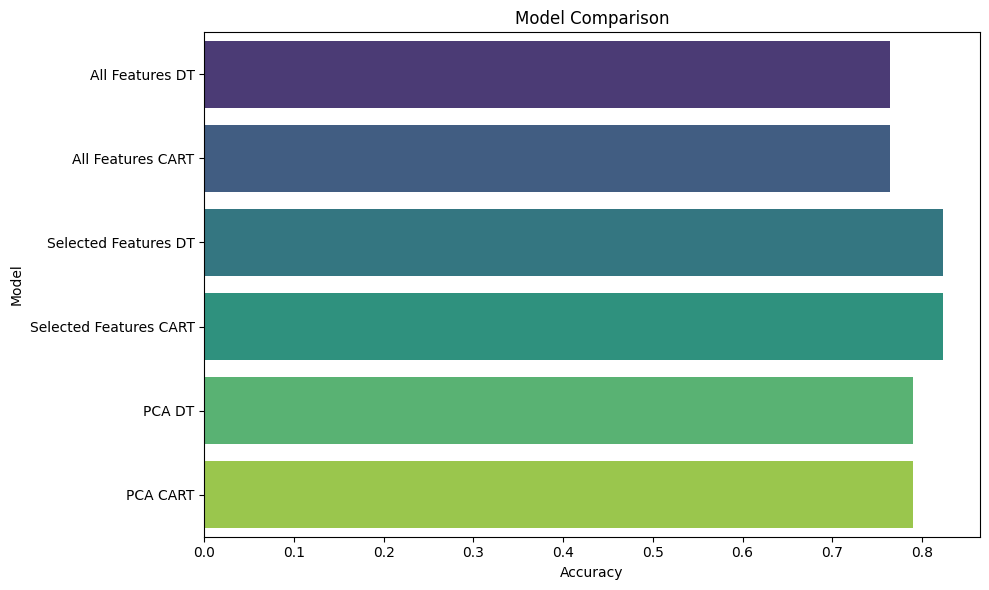


Mean Precision (DT): 0.8289
Mean Recall (DT): 0.9049
Mean Precision (CART): 0.8324
Mean Recall (CART): 0.8992


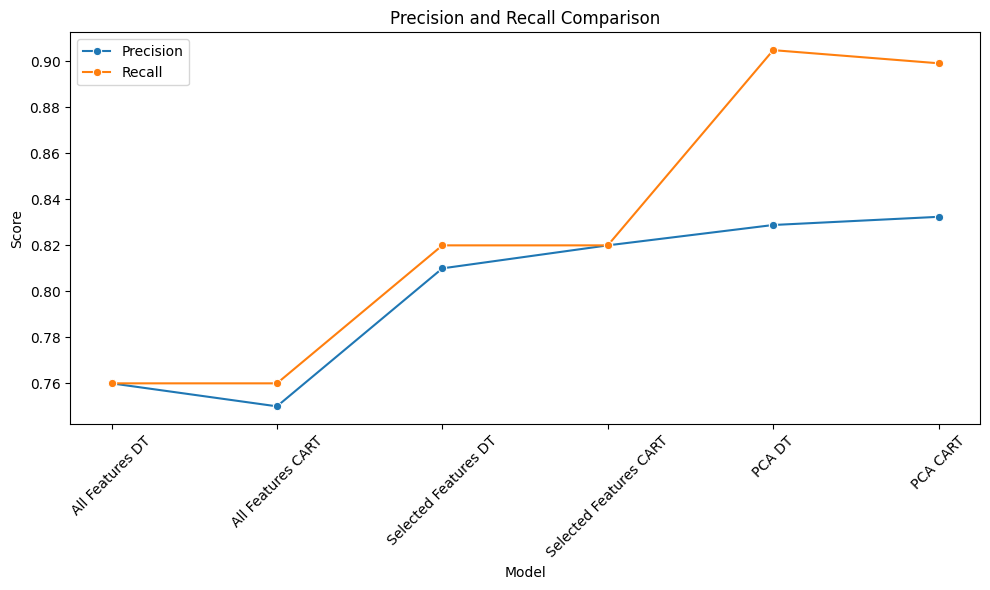

In [ ]:
# performace comparison between the two models using all features and selected features and PCA

# Create a DataFrame for the results
results = pd.DataFrame({
    'Model': ['All Features DT', 'All Features CART', 'Selected Features DT', 'Selected Features CART', 'PCA DT', 'PCA CART'],
    'Accuracy': [AllFeatures_DT_accuracy, AllFeatues_cart_accuracy, SelectedFeatures_DT_accuracy, SelectedFeatures_cart_accuracy, np.mean(DT_accuracies), np.mean(cart_accuracies)]
})

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results, palette='viridis', hue='Model')
plt.title('Model Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.tight_layout()
plt.show()


precisions = []
recalls = []

for report in [AllFeatures_DT_report, AllFeatues_cart_report, SelectedFeatures_DT_report, SelectedFeatures_cart_report]:
    lines = report.split('\n')
    precisions.append(float(lines[-2].split()[2]))
    recalls.append(float(lines[-2].split()[3]))
    
# average precision and recall from the kfold cross validation from reports
dt_mean_precision = np.mean([rep['1']['precision'] for rep in DT_reports])
dt_mean_recall = np.mean([rep['1']['recall'] for rep in DT_reports])
cart_mean_precision = np.mean([rep['1']['precision'] for rep in cart_reports])
cart_mean_recall = np.mean([rep['1']['recall'] for rep in cart_reports])


precisions.extend([dt_mean_precision, cart_mean_precision])
recalls.extend([dt_mean_recall, cart_mean_recall])

# Create a DataFrame for the results
results = pd.DataFrame({
    'Model': ['All Features DT', 'All Features CART', 'Selected Features DT', 'Selected Features CART', 'PCA DT', 'PCA CART'],
    'Precision': precisions,
    'Recall': recalls
})

# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(x='Model', y='Precision', data=results, label='Precision', marker='o')
sns.lineplot(x='Model', y='Recall', data=results, label='Recall', marker='o')
plt.title('Precision and Recall Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


